In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [3]:
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
X_train = train.iloc[:,0:27]
y_train = X_train.pop('RUL')

X_test = test.groupby('unit_nr').last().reset_index()

In [5]:
X_train

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [6]:
col= ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
train= train.drop(columns= ['setting_3','s_1','s_5','s_6','s_10','s_16','s_18','s_19'])
test= test.drop(columns= ['setting_3','s_1','s_5','s_6','s_10','s_16','s_18','s_19'])

In [7]:
train

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [8]:
X_train = train.iloc[:,0:20]
y_train = X_train.pop('RUL')

X_test = test.groupby('unit_nr').last().reset_index()

In [9]:
y_train_clipped = y_train.clip(upper=125)

In [10]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 18)
(20631, 190)


In [13]:
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train)


SVR(kernel='linear')

In [14]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [15]:
lm = LinearRegression()
clf=lm.fit(X_train_transformed, y_train)

y_hat_train1 = lm.predict(X_train_transformed)
evaluate(y_train, y_hat_train1, 'train')

y_hat_test1 = lm.predict(X_test_transformed)
evaluate(y_test, y_hat_test1)

train set RMSE:35.488086518882085, R2:0.7345471120651093
test set RMSE:26.61342698550409, R2:0.5898506199236135


In [16]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [17]:
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:30.414578922419977, R2:0.46732714052254254
test set RMSE:25.434468423443757, R2:0.6253844621602247


In [18]:
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold='mean', prefit=True)
select_features.get_support()
feature_names = poly.get_feature_names()

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 's_2', 's_3', 's_4',
       's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17',
       's_20', 's_21'],
      dtype='object')
Best features:
 ['x1' 'x4' 'x5' 'x6' 'x7' 'x9' 'x10' 'x11' 'x13' 'x14' 'x15' 'x16' 'x17'
 'x0^2' 'x0 x9' 'x0 x13' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x7' 'x1 x8' 'x1 x9'
 'x1 x11' 'x1 x12' 'x1 x13' 'x1 x16' 'x1 x17' 'x4 x13' 'x6 x13' 'x7^2'
 'x7 x9' 'x7 x11' 'x7 x13' 'x7 x16' 'x7 x17' 'x9^2' 'x9 x10' 'x9 x11'
 'x9 x16' 'x9 x17' 'x10 x12' 'x10 x13' 'x11^2' 'x11 x12' 'x11 x13'
 'x11 x16' 'x11 x17' 'x13 x16' 'x13 x17' 'x17^2']


(50,)

In [102]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

y_hat_train = svr.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = svr.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:42.9896300144978, R2:0.6104621141868578
test set RMSE:34.16271441504416, R2:0.32415796988732326


In [69]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

y_hat_train = svr.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = svr.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:42.9896300144978, R2:0.6104621141868578
test set RMSE:34.16271441504416, R2:0.32415796988732326


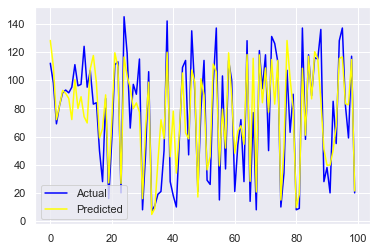

In [59]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [98]:
lm = LinearRegression()
lm.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

y_hat_train1 = lm.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train1, 'train')

y_hat_test1 = lm.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test1)

train set RMSE:17.418800768184376, R2:0.8252836868722989
test set RMSE:19.850909980550583, R2:0.7718075371435558


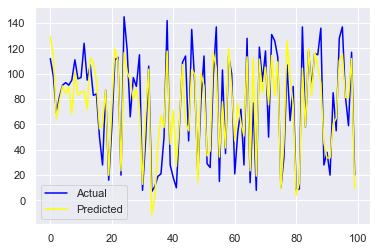

In [27]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test1,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [19]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split



In [20]:
X_trainn= X_train_transformed[:, select_features.get_support()]
split_result = train_val_group_split(X_trainn, y_train_clipped, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [21]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [22]:
train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=18, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:

epochs = 30

history = model.fit(X_train_split_scaled, y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled, y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/30
518/518 [==============================] - 1s 1ms/step - loss: 2220.3484 - val_loss: 379.2288
Epoch 2/30
518/518 [==============================] - 0s 845us/step - loss: 418.7174 - val_loss: 290.5654
Epoch 3/30
518/518 [==============================] - 0s 800us/step - loss: 381.4017 - val_loss: 269.0682
Epoch 4/30
518/518 [==============================] - 0s 856us/step - loss: 358.3589 - val_loss: 253.6196
Epoch 5/30
518/518 [==============================] - 0s 792us/step - loss: 338.3452 - val_loss: 256.2014
Epoch 6/30
518/518 [==============================] - 0s 820us/step - loss: 326.7929 - val_loss: 240.8713
Epoch 7/30
518/518 [==============================] - 0s 845us/step - loss: 316.4573 - val_loss: 238.9194
Epoch 8/30
518/518 [==============================] - 0s 829us/step - loss: 309.1704 - val_loss: 231.4514
Epoch 9/30
518/518 [==============================] - 0s 793us/step - loss: 301.9543 - val_loss: 231.9759
Epoch 10/30
518/518 [==========================

In [24]:
y_hat_train3 = model.predict(X_train_scaled)
evaluate(y_train, y_hat_train3, 'train')

y_hat_test3 = model.predict(X_test_scaled)
evaluate(y_test, y_hat_test3)

train set RMSE:47.58756139147602, R2:0.5226804877503228
test set RMSE:19.144021931362108, R2:0.7877699765468837


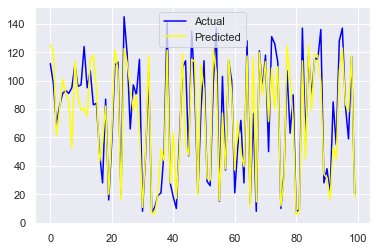

In [25]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test3,c='yellow',label='Predicted')
plt.legend()
plt.show()

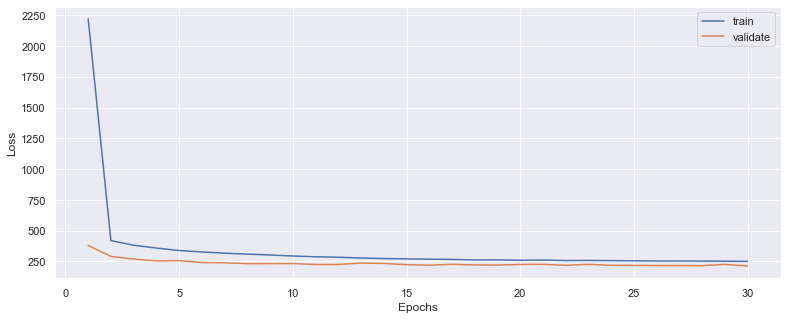

In [26]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [14]:
# choose the model
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', gb) ])

In [13]:
# tune the model
my_alpha = [.5, .75, .9]
my_n_estimators= [500]
my_learning_rate = [0.005, .01]
my_max_depth = [4, 5, 6]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_gb = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__max_depth = my_max_depth, model__n_estimators = my_n_estimators,
                                              model__learning_rate = my_learning_rate, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_gb.fit(X_train_transformed[:, select_features.get_support()], y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardize', StandardScaler()),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.5, 0.75, 0.9],
                         'model__learning_rate': [0.005, 0.01],
                         'model__max_depth': [4, 5, 6],
                         'model__n_estimators': [500]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# show the best model estimators
print(optimized_gb.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_gb.predict(X_test_transformed[:, select_features.get_support()])
print("Gradient Boosting Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Gradient Boosting Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Gradient Boosting r-squared: ", r2_score(y_test, y_pred))

Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(alpha=0.5, learning_rate=0.005,
                                           max_depth=4, n_estimators=500))])
Gradient Boosting Mean Squared Error:  357.8195753598182
Gradient Boosting Mean Absolute Error:  14.559131129898253
Gradient Boosting r-squared:  0.7927929385288743


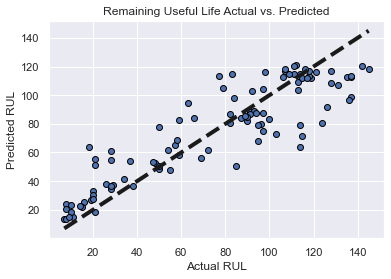

In [15]:
# plot actual vs predicted Remaining Useful Life for the best model (GBM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [27]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, HuberRegressor, Lasso
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

,R-squared
Lasso,0.717522
AdaBoost,0.765047
Ridge,0.826485
Huber,0.826593
Linear,0.827949
BayesianRidge,0.828026
SVM,0.837524
Neural Network,0.847022
Bagging,0.855314
RandomForest,0.869165


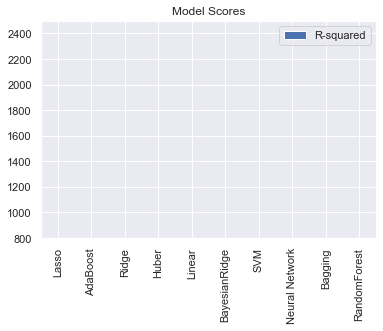

In [21]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train_transformed[:, select_features.get_support()], y_train)

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

,R-squared
Lasso,0.720659
AdaBoost,0.754083
Huber,0.823656
SVM,0.825508
Linear,0.826952
Ridge,0.826958
BayesianRidge,0.827817
Neural Network,0.854723
Bagging,0.867025
RandomForest,0.879801


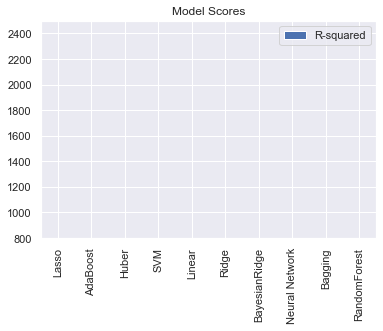

In [22]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train_transformed, y_train)

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,R-squared
SVM,-0.123597
Neural Network,0.547929
Huber,0.731864
AdaBoost,0.735598
Lasso,0.758235
Linear,0.772695
BayesianRidge,0.772849
Ridge,0.772868
Bagging,0.884925
RandomForest,0.898027


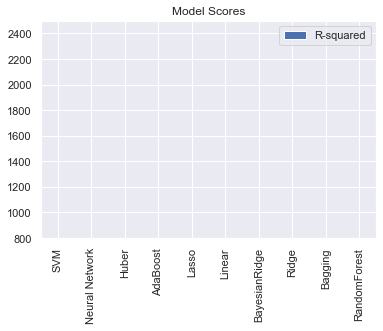

In [23]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train, y_train)

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

,R-squared
Lasso,0.709836
AdaBoost,0.748652
Huber,0.772054
Linear,0.772695
BayesianRidge,0.772744
Ridge,0.772763
Neural Network,0.821515
SVM,0.830407
Bagging,0.885337
RandomForest,0.897406


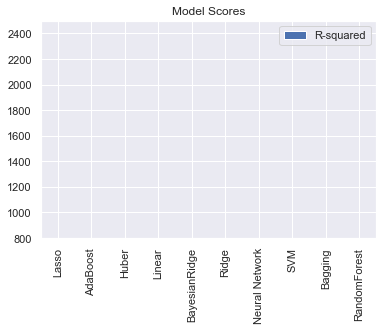

In [24]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train_scaled, y_train)

In [25]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [28]:
def get_RUL(engine_data):
    
    # The binary_class will be 0 if RUL > 30. The binary_class will be 1 if RUL <= 30
    engine_data["binary_class"] = engine_data["RUL"].map(lambda x: 1 if x <= 30 else 0)
    
    # The multi_class will be 0 if RUL > 30. The multi_class will be 1 if  15 < RUL <= 30. 
    # The multi_class will be 2 if RUL <= 15
    engine_data["multi_class"] = engine_data["RUL"].map(lambda x: 2 if x <= 15 else 1 if x<= 30 else 0)
    return engine_data

train_labels = get_RUL(train.copy(deep=True))
RUL_train = train_labels["RUL"]
binary_class_train = train_labels["binary_class"]
multi_class_train = train_labels["multi_class"]

train_labels

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,...,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,binary_class,multi_class
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,...,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,1,2
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,...,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,1,2
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,...,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,1,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,...,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,1,2


In [29]:
# Label Test Data

# RUL_FD001.txt contains the RUL for the last cycle for all the engines in the test data set
# In the test set, the time series ends some time before the system failure.
remaining_RUL_test = pd.read_csv("RUL_FD001.txt", header=None)
remaining_RUL_test["unit_nr"] = remaining_RUL_test.index + 1


def get_RUL_test(engine_data_test, remaining_RUL_test):
    # Get the last cycle for all the engines in the test data set
    last_cycle = engine_data_test.copy(deep=True).groupby(['unit_nr'])["time_cycles"].max().reset_index()
    
    # Since remaining_RUL_test contains RUL only for the last cycle in the test data set, 
    # we only keep the last cycle for each engine in the test data set
    final = pd.merge(last_cycle, engine_data_test.copy(deep=True), how="inner", on=["unit_nr", "time_cycles"])
    final = pd.merge(final, remaining_RUL_test, how="inner", on=["unit_nr"])
    final["RUL"] = final[0]
    # The binary_class will be 0 if RUL > 30. The binary_class will be 1 if RUL <= 30
    final["binary_class"] = final["RUL"].map(lambda x: 1 if x <= 30 else 0)
    # The multi_class will be 0 if RUL > 30. The multi_class will be 1 if  15 < RUL <= 30. 
    # The multi_class will be 2 if RUL <= 15
    final["multi_class"] = final["RUL"].map(lambda x: 2 if x <= 15 else 1 if x<= 30 else 0)
    return final

test_labels = get_RUL_test(test.copy(deep=True), remaining_RUL_test)
RUL_test = test_labels["RUL"]
binary_class_test = test_labels["binary_class"]
multi_class_test = test_labels["multi_class"]

test_labels

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,...,s_13,s_14,s_15,s_17,s_20,s_21,0,RUL,binary_class,multi_class
0,1,31,-0.0006,0.0004,642.58,1581.22,1398.91,554.42,2388.08,9056.40,...,2388.06,8130.11,8.4024,393,38.81,23.3552,112,112,0,0
1,2,49,0.0018,-0.0001,642.55,1586.59,1410.83,553.52,2388.10,9044.77,...,2388.09,8126.90,8.4505,391,38.81,23.2618,98,98,0,0
2,3,126,-0.0016,0.0004,642.88,1589.75,1418.89,552.59,2388.16,9049.26,...,2388.14,8131.46,8.4119,395,38.93,23.2740,69,69,0,0
3,4,106,0.0012,0.0004,642.78,1594.53,1406.88,552.64,2388.13,9051.30,...,2388.11,8133.64,8.4634,395,38.58,23.2581,82,82,0,0
4,5,98,-0.0013,-0.0004,642.27,1589.94,1419.36,553.29,2388.10,9053.99,...,2388.15,8125.74,8.4362,394,38.75,23.4117,91,91,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,642.30,1590.88,1397.94,553.99,2388.03,9062.41,...,2388.01,8148.24,8.4110,391,38.96,23.4606,137,137,0,0
96,97,134,0.0013,-0.0001,642.59,1582.96,1410.92,554.05,2388.06,9076.36,...,2388.06,8155.48,8.4500,395,38.61,23.2953,82,82,0,0
97,98,121,0.0017,0.0001,642.68,1599.51,1415.47,553.44,2388.13,9062.34,...,2388.09,8146.39,8.4235,394,38.76,23.3608,59,59,0,0
98,99,97,0.0047,-0.0000,642.00,1585.03,1397.98,554.75,2388.01,9067.16,...,2388.02,8150.38,8.4003,391,38.95,23.3595,117,117,0,0


KNeighbors
SVC
GaussianProcess
GaussianNB
QuadraticDiscriminantAnalysis
Neural Network
AdaBoost
Decision Tree
RandomForest


,Accuracy
SVM,0.964519
GaussianProcess,0.963356
AdaBoost,0.960642
KNeighbors,0.959236
Neural Network,0.959236
RandomForest,0.956958
Decision Tree,0.953226
QuadraticDiscriminantAnalysis,0.936455
GaussianNB,0.922495


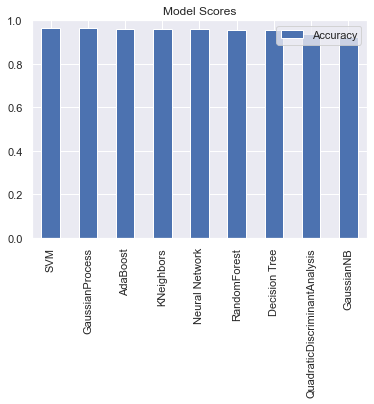

In [29]:
def analyse_binary_classification_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        accuracy = make_scorer(accuracy_score)
        accuracy_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=accuracy)
        scores = [accuracy_val_score.mean()]
        return scores
    
    clf = KNeighborsClassifier(3)
    print("KNeighbors")
    results["KNeighbors"] = test_model(clf)
    
    clf = SVC()
    print("SVC")
    results["SVM"] = test_model(clf)
    
    clf = GaussianProcessClassifier()
    print("GaussianProcess")
    results["GaussianProcess"] = test_model(clf)
    
    clf = GaussianNB()
    print("GaussianNB")
    results["GaussianNB"] = test_model(clf)
    
    clf = QuadraticDiscriminantAnalysis()
    print("QuadraticDiscriminantAnalysis")
    results["QuadraticDiscriminantAnalysis"] = test_model(clf)
    
    clf = MLPClassifier(alpha=1)
    print("Neural Network")
    results["Neural Network"] = test_model(clf)
    
    clf = AdaBoostClassifier()
    print("AdaBoost")
    results["AdaBoost"] = test_model(clf)
    
    clf = DecisionTreeClassifier(max_depth=5)
    print("Decision Tree")
    results["Decision Tree"] = test_model(clf)
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    print("RandomForest")
    results["RandomForest"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Accuracy"] 
    results = results.sort_values(by=["Accuracy"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    return results

analyse_binary_classification_models(X_train_transformed[:, select_features.get_support()], binary_class_train)

KNeighbors
SVC
GaussianNB
QuadraticDiscriminantAnalysis


C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Neural Network
AdaBoost
Decision Tree
RandomForest


,Accuracy
SVM,0.964228
AdaBoost,0.960448
Neural Network,0.959575
RandomForest,0.957152
KNeighbors,0.956182
Decision Tree,0.955504
QuadraticDiscriminantAnalysis,0.947264
GaussianNB,0.928651


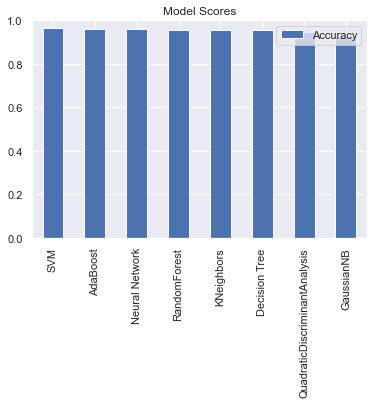

In [30]:
def analyse_binary_classification_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        accuracy = make_scorer(accuracy_score)
        accuracy_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=accuracy)
        scores = [accuracy_val_score.mean()]
        return scores
    
    clf = KNeighborsClassifier(3)
    print("KNeighbors")
    results["KNeighbors"] = test_model(clf)
    
    clf = SVC()
    print("SVC")
    results["SVM"] = test_model(clf)
    
    
    clf = GaussianNB()
    print("GaussianNB")
    results["GaussianNB"] = test_model(clf)
    
    clf = QuadraticDiscriminantAnalysis()
    print("QuadraticDiscriminantAnalysis")
    results["QuadraticDiscriminantAnalysis"] = test_model(clf)
    
    clf = MLPClassifier(alpha=1)
    print("Neural Network")
    results["Neural Network"] = test_model(clf)
    
    clf = AdaBoostClassifier()
    print("AdaBoost")
    results["AdaBoost"] = test_model(clf)
    
    clf = DecisionTreeClassifier(max_depth=5)
    print("Decision Tree")
    results["Decision Tree"] = test_model(clf)
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    print("RandomForest")
    results["RandomForest"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Accuracy"] 
    results = results.sort_values(by=["Accuracy"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    return results

analyse_binary_classification_models(X_train_transformed, binary_class_train)

In [31]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier


cv = KFold(n_splits=2, shuffle=True, random_state=20)

# Parameter list for tuning
parameters = {
    'learning_rate': [0.7, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [12, 25, 50, 100]
}

# Initialise AdaBoostClassifier
clf = AdaBoostClassifier(random_state=20)

accuracy = make_scorer(accuracy_score)

# Perform Grid Search using accuracy as the scoring method
grid_obj = GridSearchCV(clf, parameters, cv=cv, scoring=accuracy)

# Fit the grid search to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train_transformed[:, select_features.get_support()], binary_class_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_ 
print(best_clf)

best_clf.fit(X_train_transformed[:, select_features.get_support()], binary_class_train)

binary_class_predictions = best_clf.predict(X_test_transformed[:, select_features.get_support()])

print("Accuracy: " + str(accuracy_score(binary_class_predictions, binary_class_test)))

AdaBoostClassifier(learning_rate=0.7, n_estimators=100, random_state=20)
Accuracy: 0.94


KNeighbors
SVC
QuadraticDiscriminantAnalysis
Neural Network
AdaBoost
Decision Tree
RandomForest


,Accuracy
AdaBoost,0.937909
SVM,0.936115
KNeighbors,0.933498
Neural Network,0.932625
RandomForest,0.926712
Decision Tree,0.926324
QuadraticDiscriminantAnalysis,0.903301


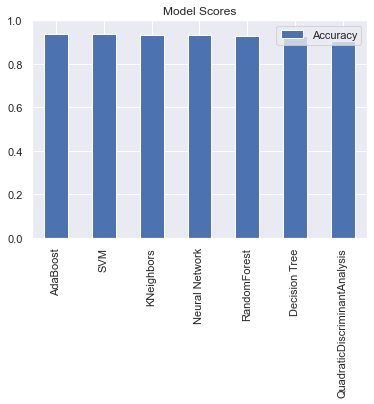

In [33]:

# Multiclass Model selection (Multiclass classification)

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier



def analyse_multiclass_classification_models(train, labels):
    results = {}
    
    def test_model(clf):
        clf = OneVsRestClassifier(clf)
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        accuracy = make_scorer(accuracy_score)
        accuracy_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=accuracy)
        scores = [accuracy_val_score.mean()]
        return scores
    
    clf = KNeighborsClassifier(3)
    print("KNeighbors")
    results["KNeighbors"] = test_model(clf)
    
    clf = SVC()
    print("SVC")
    results["SVM"] = test_model(clf)
    

    
    clf = QuadraticDiscriminantAnalysis()
    print("QuadraticDiscriminantAnalysis")
    results["QuadraticDiscriminantAnalysis"] = test_model(clf)
    
    clf = MLPClassifier(alpha=1)
    print("Neural Network")
    results["Neural Network"] = test_model(clf)
    
    clf = AdaBoostClassifier()
    print("AdaBoost")
    results["AdaBoost"] = test_model(clf)
    
    clf = DecisionTreeClassifier(max_depth=5)
    print("Decision Tree")
    results["Decision Tree"] = test_model(clf)
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    print("RandomForest")
    results["RandomForest"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Accuracy"] 
    results = results.sort_values(by=["Accuracy"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    return results

analyse_multiclass_classification_models(X_train_transformed[:, select_features.get_support()], multi_class_train)

In [34]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier


cv = KFold(n_splits=2, shuffle=True, random_state=20)

# Parameter list for tuning
parameters = {
    'learning_rate': [0.7, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [200, 50]
}

# Initialise AdaBoostClassifier
clf = AdaBoostClassifier(random_state=20)

accuracy = make_scorer(accuracy_score)

# Perform Grid Search using accuracy as the scoring method
grid_obj = GridSearchCV(clf, parameters, cv=cv, scoring=accuracy)

# Fit the grid search to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train_transformed[:, select_features.get_support()], multi_class_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_ 
best_clf = OneVsRestClassifier(best_clf)
print(best_clf)

best_clf.fit(X_train_transformed[:, select_features.get_support()], multi_class_train)

multi_class_predictions = best_clf.predict(X_test_transformed[:, select_features.get_support()])

print("Accuracy: " + str(accuracy_score(multi_class_predictions, multi_class_test)))

OneVsRestClassifier(estimator=AdaBoostClassifier(learning_rate=1,
                                                 n_estimators=200,
                                                 random_state=20))
Accuracy: 0.92


In [42]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)


In [72]:
clf.fit(X_train_transformed[:, select_features.get_support()], multi_class_train)

y_pred3=clf.predict(X_test_transformed[:, select_features.get_support()])

In [73]:
print("Accuracy: " + str(accuracy_score(y_pred3, multi_class_test)))

Accuracy: 0.83


In [44]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(binary_class_test, y_pred))

Accuracy: 0.91


In [45]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve


In [47]:
def print_results(y_test, y_pred, multi_class = False):
    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area under curve : ",model_roc_auc,"\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)

        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

F1 Score:  0.7906976744186047
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100

Area under curve :  0.8333333333333335 



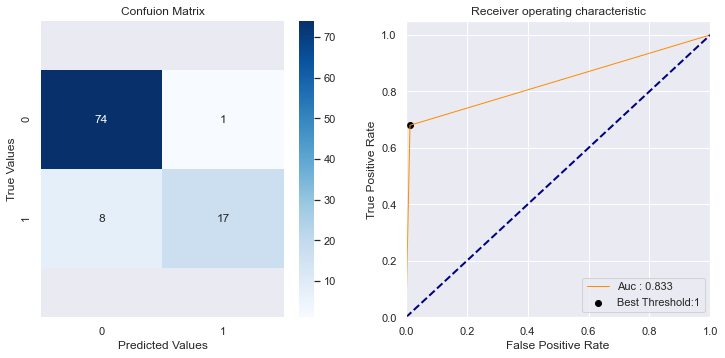

In [48]:
print_results(binary_class_test, y_pred)


In [50]:
cf_matrix = confusion_matrix(binary_class_test, y_pred)
print(cf_matrix)

[[74  1]
 [ 8 17]]


<AxesSubplot:>

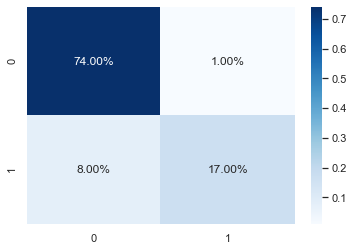

In [51]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [52]:
group_names = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
group_counts = [“{0:0.0f}”.format(value) for value in
                cf_matrix.flatten()]
group_percentages = [“{0:.2%}”.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f”{v1}\n{v2}\n{v3}” for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt=‘’, cmap='Blues')

SyntaxError: invalid character in identifier (<ipython-input-52-8f2582a787d2>, line 1)

<AxesSubplot:>

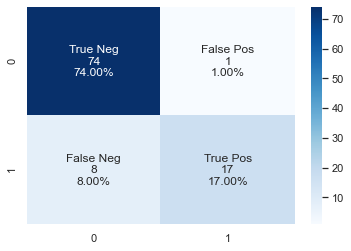

In [61]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [62]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier


In [78]:
clf = DecisionTreeClassifier()


In [79]:
clf2 = clf.fit(X_train_transformed[:, select_features.get_support()], binary_class_train)


In [80]:
y_pred2 = clf2.predict(X_test_transformed[:, select_features.get_support()])


In [81]:
print("Accuracy:",metrics.accuracy_score(binary_class_test, y_pred2))


Accuracy: 0.9


In [82]:
clf3 = clf2.fit(X_train_transformed[:, select_features.get_support()], multi_class_train)
y_pred4 = clf3.predict(X_test_transformed[:, select_features.get_support()])
print("Accuracy:",metrics.accuracy_score(multi_class_test, y_pred4))


Accuracy: 0.83


F1 Score:  0.782608695652174
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        75
           1       0.86      0.72      0.78        25

    accuracy                           0.90       100
   macro avg       0.88      0.84      0.86       100
weighted avg       0.90      0.90      0.90       100

Area under curve :  0.84 



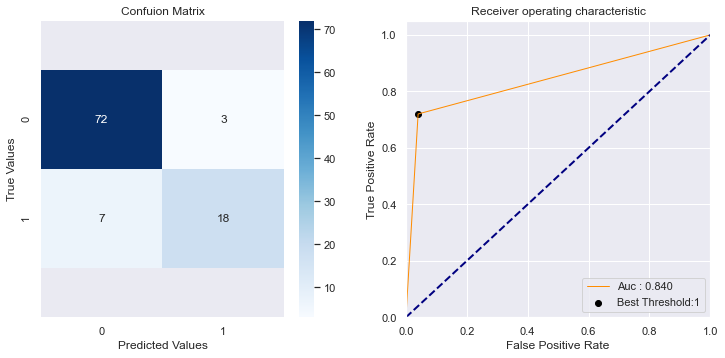

In [86]:
print_results(binary_class_test, y_pred2)


In [87]:
from sklearn.svm import SVC
svc=SVC() 

In [88]:
svc.fit(X_train_transformed[:, select_features.get_support()], binary_class_train)

SVC()

In [89]:
y_pred5=svc.predict(X_test_transformed[:, select_features.get_support()])

In [90]:
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(binary_class_test, y_pred5)))

Model accuracy score with default hyperparameters: 0.9300


F1 Score:  0.8372093023255813
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        75
           1       1.00      0.72      0.84        25

    accuracy                           0.93       100
   macro avg       0.96      0.86      0.90       100
weighted avg       0.94      0.93      0.93       100

Area under curve :  0.86 



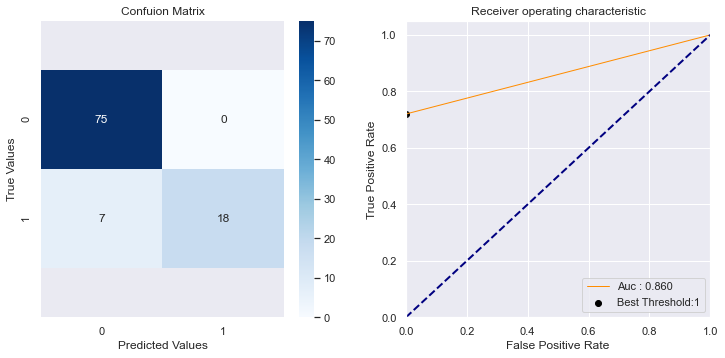

In [91]:
print_results(binary_class_test, y_pred5)